In [50]:
import horton
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

In [43]:
def get_n2_energy(bond_length, basis_set, use_CO_basis=False):
    horton.log.set_level(0)

    mol = horton.IOData()
    bond_length = float(bond_length)
    mol.coordinates = np.array([[0.0, 0.0, -bond_length/2.], [0.0, 0.0, bond_length/2.]]) * horton.angstrom
    mol.numbers = np.array([7., 7.])
    mol.pseudo_numbers = mol.numbers
    
    if use_CO_basis:
        obasis = horton.get_gobasis(mol.coordinates, np.array([7, 7]), basis_set)
    else:
        obasis = horton.get_gobasis(mol.coordinates, np.array([8, 6]), basis_set)
    
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)
    
    horton.guess_core_hamiltonian(olp, kin + na, orb_alpha, orb_beta)
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    
    terms = [horton.UTwoIndexTerm(kin, 'kin'), horton.UDirectTerm(er, 'hartree'), horton.UExchangeTerm(er, 'x_hf'), horton.UTwoIndexTerm(na, 'ne')]
    ham = horton.UEffHam(terms, external)
    occ_model = horton.AufbauOccModel(7, 7)
    occ_model.assign(orb_alpha, orb_beta)
    dm_alpha = orb_alpha.to_dm()
    dm_beta = orb_beta.to_dm()
    scf_solver = horton.ODASCFSolver(1e-6, maxiter=400)
    scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
    
    return ham.compute_energy()

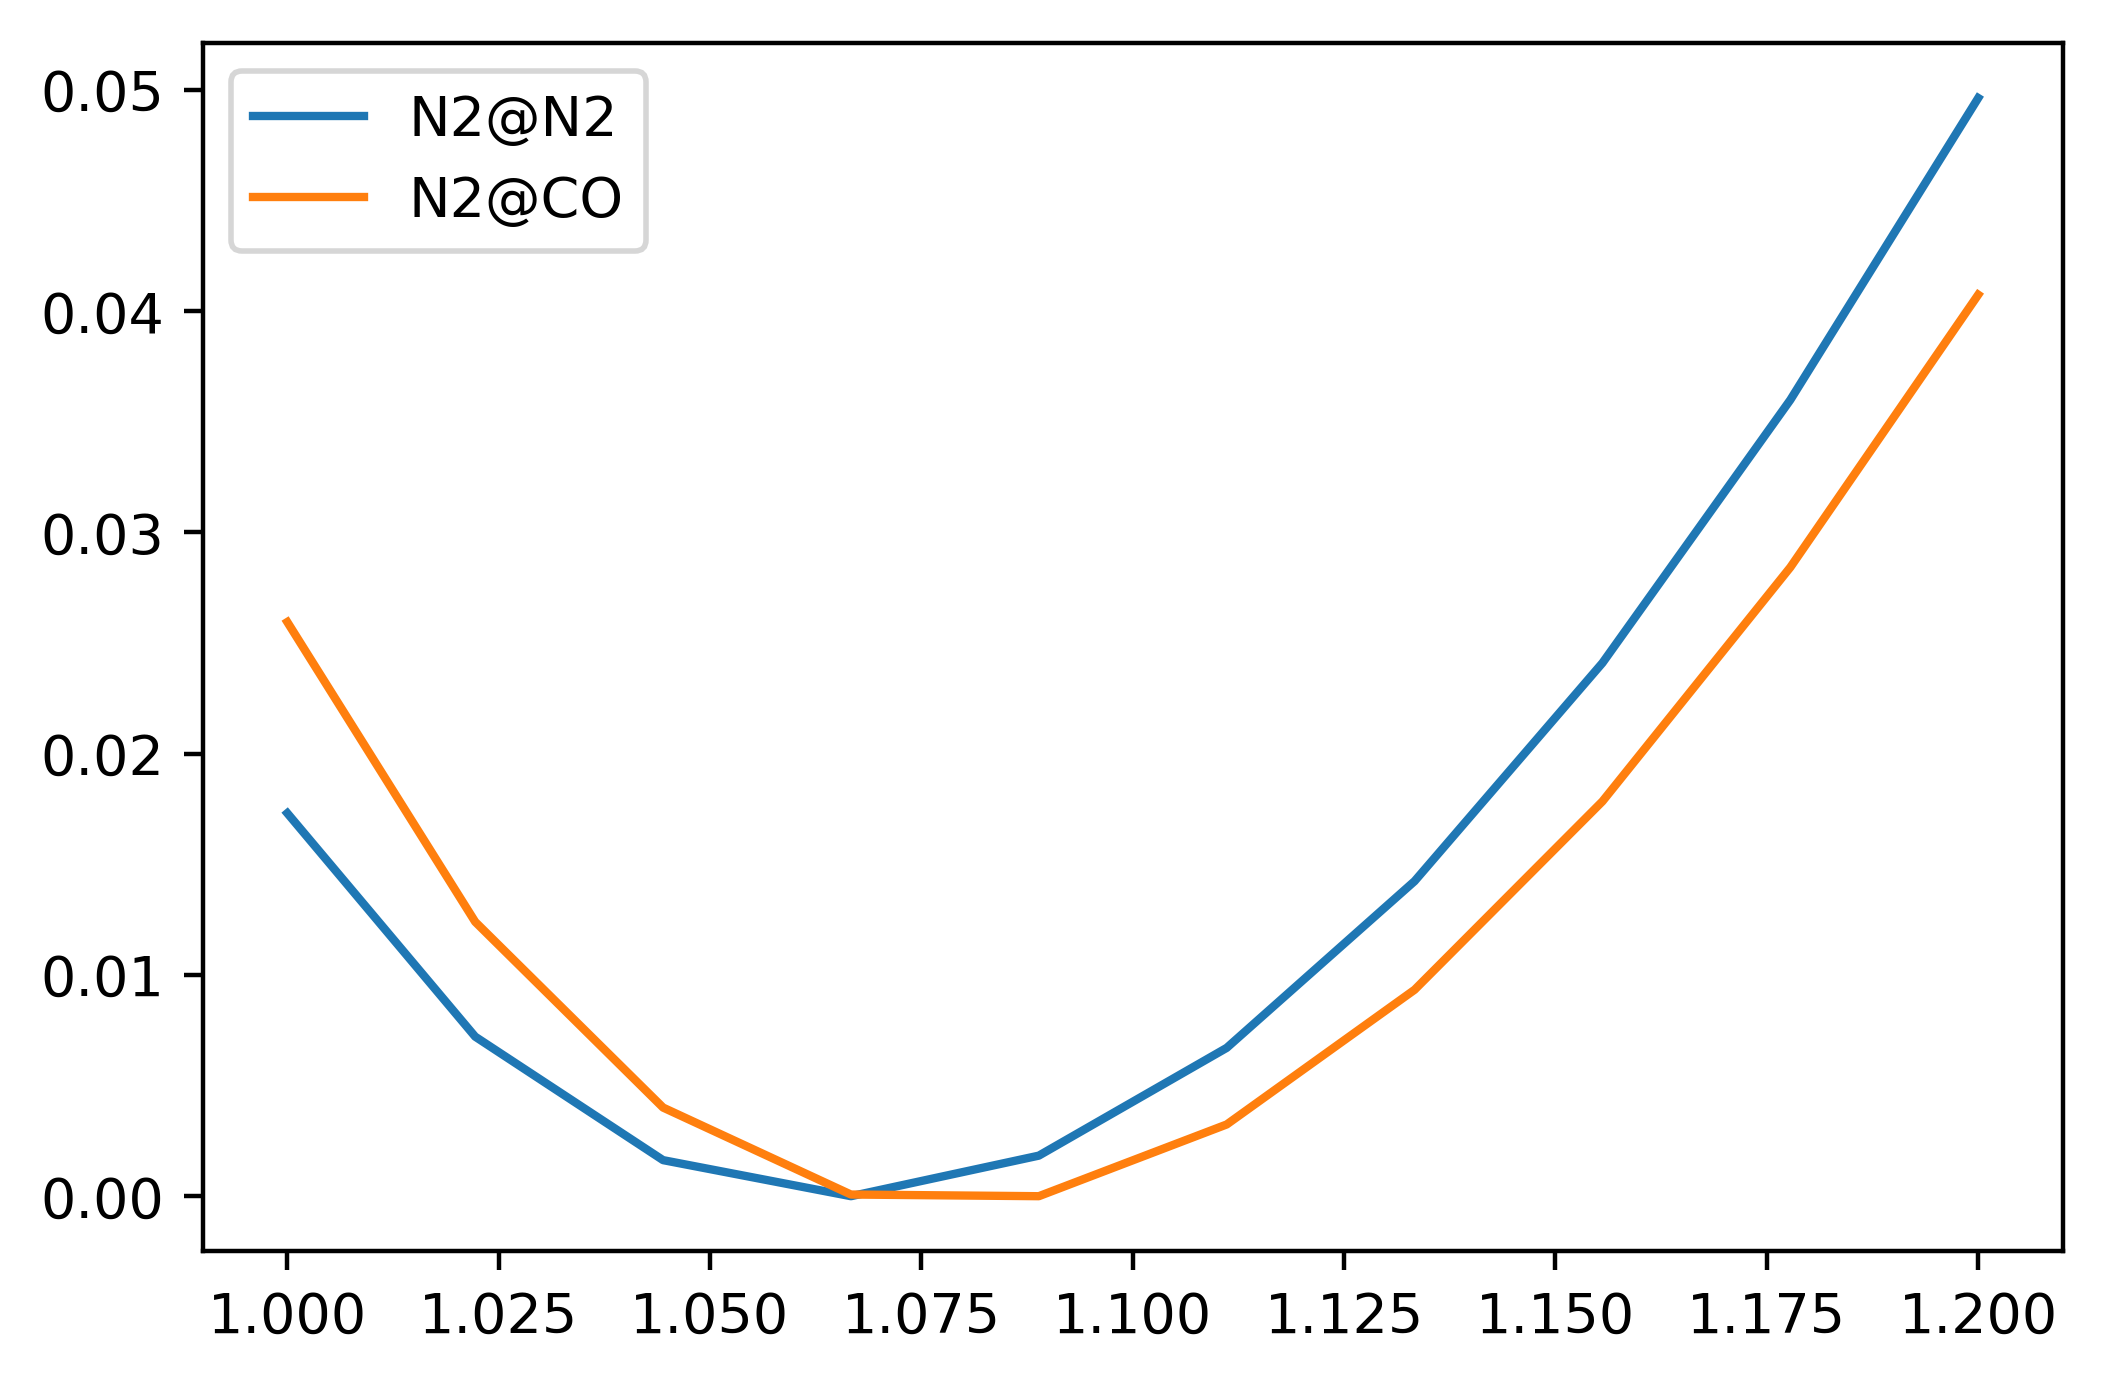

In [86]:
f = plt.figure(dpi=400)
basisset = '6-31G(d)'
ds = np.linspace(1.0, 1.2, 10)
ysn2 = [get_n2_energy(_, basisset, False)  for _ in ds]
ysco = [get_n2_energy(_, basisset, True)  for _ in ds]
plt.plot(ds, ysn2-min(ysn2), label='N2@N2')
plt.plot(ds, ysco-min(ysco), label='N2@CO')
plt.legend()

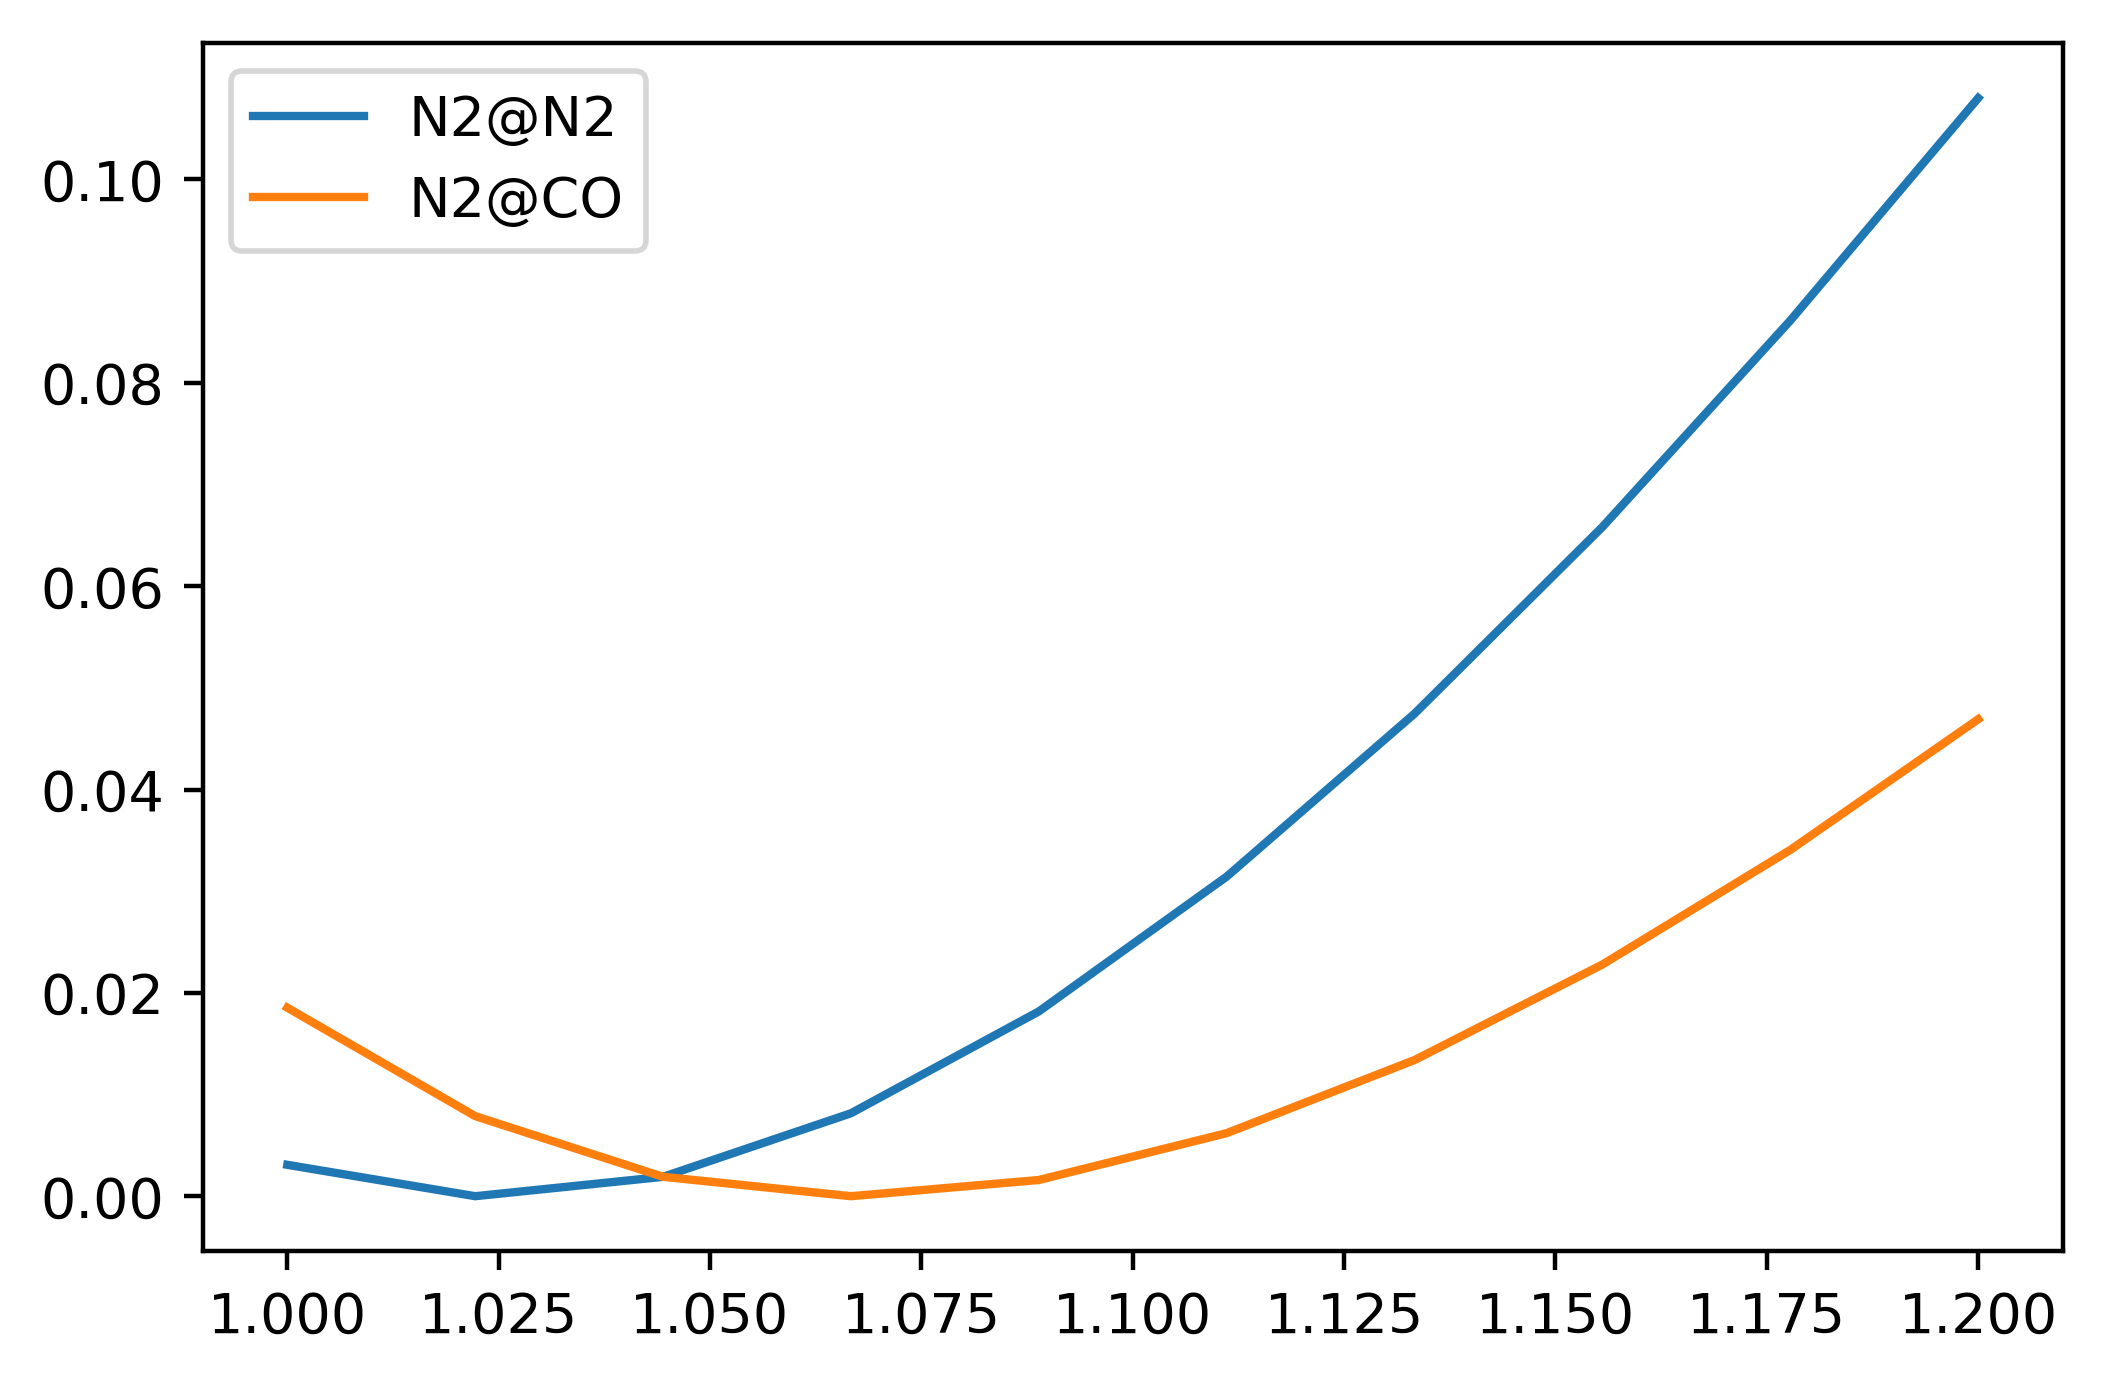

In [88]:
f = plt.figure(dpi=400)
basisset = 'cc-pvtz'
ds = np.linspace(1.0, 1.2, 10)
ysn2 = [get_n2_energy(_, basisset, False)  for _ in ds]
ysco = [get_n2_energy(_, basisset, True)  for _ in ds]
plt.plot(ds, ysn2-min(ysn2), label='N2@N2')
plt.plot(ds, ysco-min(ysco), label='N2@CO')
plt.legend()

In [48]:
#for basisset in ('STO-3G', '6-31G(d)', 'Def2-TZVP', 'cc-pvtz'):
    #print (basisset, get_n2_energy(2., basisset, True) - get_n2_energy(2., basisset, False))

In [78]:
Mu_NN=horton.periodic['n'].mass/2.

def to_cm(k,Mu=Mu_NN):
    return (k/Mu)**0.5*horton.centimeter/horton.planck/horton.lightspeed
def FivePointDerivatives(x,h, callback):
   # '''a prediction of the minimum of a function based on a 4 point approx'''
    points =[]
    for i in range (5):
        points.append(callback(x+h*(i-2)))
    fd4=(points[4]-points[3]*4+points[2]*6-points[1]*4+points[0])/h**4
    fd3=(points[4]-2*points[3]+2*points[1]-points[0])/(2*h**3)
    fd1=(points[3]-points[1]-h**3*fd3/3.)/2/h
    fd2=(points[3]-2*points[2]+points[1]-h**4/12.*fd4)/(h**2)
    
    print 'the derivatives are:', fd1,fd2,fd3, fd4, 'to cm:' ,to_cm(fd2)
    return (x,points[2],fd1,fd2,fd3,fd4)

def dx4f2(x,e,d1,d2,d3,d4):
    a=d4/6.
    b=d3/2.
    c=d2
    d=d1
    D0=b**2-3*a*c
    D1=2*b**3-9*a*b*c+27*a**2*d
    C=((D1+(D1**2-4*D0**3)**0.5)/2.)**(1/3.)
    dx=-(b+C+D0/C)/(3.*a)
    p2d=d2+dx*d3+0.5*d4*dx**2
    return x+dx, to_cm(p2d), e+d1*dx+d2*dx**2/2

the derivatives are: -9.274927433485393e-06 1.9878785442273283 -7.167843098621062 24.882922389224404 to cm: 2738.6962370337906
2738.5187816369025
the derivatives are: -2.9335955294603103e-06 1.981651943886812 -7.075049957450118 27.845472683196704 to cm: 2734.4036856971316
2733.4263450058997


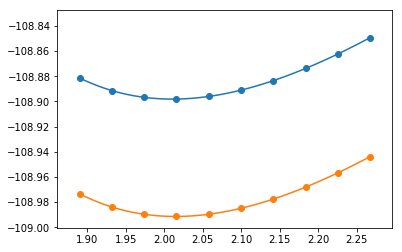

In [85]:
def spline_then_minimum(ys):
    dsq = ds*horton.angstrom
    spl = CubicSpline(dsq, ys)
    plt.scatter(dsq, ys)
    xss = np.linspace(min(dsq), max(dsq), 50)
    yss = spl(xss)
    plt.plot(xss, yss)
    minimum = spl.derivative().roots()[0]
    FivePointDerivatives(minimum, 0.02, spl)
    print (to_cm(spl.derivative(2)(minimum)))
    
spline_then_minimum(ysn2)
spline_then_minimum(ysco)

the derivatives are: -4.545121967680643e-06 1.972883650121678 -6.148478457035366 24.636230033792117 to cm: 2728.347466881459
2727.683135817095
the derivatives are: -8.277696158150341e-07 2.0220653742934283 -7.23507837996351 12.630624368625831 to cm: 2762.1454123618346
2762.4329550370185


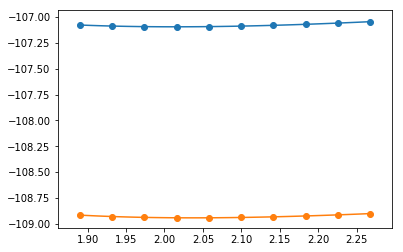

In [87]:
def spline_then_minimum(ys):
    dsq = ds*horton.angstrom
    spl = CubicSpline(dsq, ys)
    plt.scatter(dsq, ys)
    xss = np.linspace(min(dsq), max(dsq), 50)
    yss = spl(xss)
    plt.plot(xss, yss)
    minimum = spl.derivative().roots()[0]
    FivePointDerivatives(minimum, 0.02, spl)
    print (to_cm(spl.derivative(2)(minimum)))
    
spline_then_minimum(ysn2)
spline_then_minimum(ysco)

the derivatives are: -7.242739741286641e-09 2.794452748326274 -8.905915117374262 0.010863399069194202 to cm: 3247.1124376574585
3247.11264800812
the derivatives are: 2.195463248237227e-06 1.9764493170034332 -7.003522815907103 27.588394146960127 to cm: 2730.811876416115
2729.768576403047


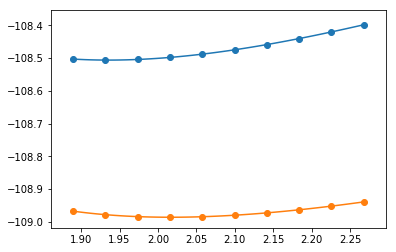

In [89]:
def spline_then_minimum(ys):
    dsq = ds*horton.angstrom
    spl = CubicSpline(dsq, ys)
    plt.scatter(dsq, ys)
    xss = np.linspace(min(dsq), max(dsq), 50)
    yss = spl(xss)
    plt.plot(xss, yss)
    minimum = spl.derivative().roots()[0]
    FivePointDerivatives(minimum, 0.02, spl)
    print (to_cm(spl.derivative(2)(minimum)))
    
spline_then_minimum(ysn2)
spline_then_minimum(ysco)